In [1]:
# Dependencies
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Reading the cleaned 25% sample data from csv to use forward
data_df = pd.read_csv('sample_data_cleaned.csv')
# ------ TEMPORARY ----------
data_df = data_df.sample(frac=.25)

In [3]:
#Understanding the data structure before we moved on
data_df.tail()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
8385264,30108681,2010-09-10 07:47:18.0000001,7.3,2010-09-10 07:47:18 UTC,-73.961147,40.812078,-73.954867,40.824077,3
6477368,35945163,2012-02-21 14:56:00.000000196,5.7,2012-02-21 14:56:00 UTC,0.000000,0.000000,0.000000,0.000000,5
4917606,45004244,2009-06-04 15:55:32.0000004,11.3,2009-06-04 15:55:32 UTC,-74.003491,40.748309,-73.976469,40.723243,1
13725505,41124600,2009-08-27 11:04:00.000000146,7.7,2009-08-27 11:04:00 UTC,-73.963960,40.767928,-73.979590,40.781098,1
13831322,4679818,2012-01-14 20:54:00.00000037,4.1,2012-01-14 20:54:00 UTC,-73.975385,40.733210,-73.976562,40.739562,2


In [4]:
#Our weather data only includes data from 2013 - 2016, so in our sampled data,
#we also filtered out data from the other years
data_df['new_time'] = (data_df['pickup_datetime']).apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z"))    
data_df = data_df.drop(['Unnamed: 0','key','pickup_datetime'], axis=1)
time_range = (data_df['new_time'] > "2013-01-01") & (data_df['new_time'] < "2016-12-31")
ranged_data = data_df.loc[time_range]

In [5]:
#calculate the distance between pick-up and drop-off spot in kilometer
def distance(row):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = row['pickup_latitude'], row['pickup_longitude']
    lat2, lon2 = row['dropoff_latitude'], row['dropoff_longitude']
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

#apply the distance calculation function into the dataframe
ranged_data['distance'] = data_df.apply(distance, axis=1)

#Clean out travel distance that is more than 100 km (data analysis is limited in NYC)
ranged_data = ranged_data[ranged_data['distance'] < 100]

In [6]:
#We separate the timestamp data into year, hour, weekday, and date for future time series analayis
ranged_data['year'] = data_df['new_time'].apply(lambda x: x.year)
ranged_data['hour_of_day'] = data_df['new_time'].apply(lambda x: x.hour)
ranged_data['day'] = data_df['new_time'].apply(lambda x: calendar.day_name[x.weekday()])
ranged_data['date'] = data_df['new_time'].apply(lambda x: x.date())

#plt.scatter(ranged_data['hour_of_day'],ranged_data['fare_amount'])

In [9]:
#Correlation analysis between travel distance and taxi fares
dummied_data = ranged_data

for column in dummied_data.columns:
 if dummied_data[column].dtype==object:
  dummyCols=pd.get_dummies(dummied_data[column])
  dummied_data=dummied_data.join(dummyCols)
  del dummied_data[column]

fares = dummied_data['fare_amount']
dummied_data.drop(['fare_amount','pickup_longitude', 'pickup_latitude','dropoff_longitude','new_time'], axis=1,inplace=True)


model_1=LinearRegression()
model_1.fit(dummied_data,fares)
coefficients=pd.DataFrame({'name':list(dummied_data),'value':model_1.coef_})
print("Mean squared error:",np.mean((model_1.predict(dummied_data) - fares) ** 2))
print("R²:",model_1.score(dummied_data, fares))

Mean squared error: 6851.039247774416
R²: 0.013823916934287306


In [7]:
ranged_data = ranged_data.drop(ranged_data[ranged_data['passenger_count'] == 0].index)
ranged_data.sort_values(by='passenger_count')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_time,distance,year,hour_of_day,day,date
5478373,8.50,-74.005730,40.740177,-73.988960,40.726700,1,2015-02-22 02:56:22,2.059684,2015,2,Sunday,2015-02-22
3036990,7.50,-73.981018,40.764237,-73.994997,40.745015,1,2013-08-24 13:28:00,2.440261,2013,13,Saturday,2013-08-24
13035749,5.00,-73.964313,40.770312,-73.961327,40.777820,1,2014-03-09 16:14:00,0.871894,2014,16,Sunday,2014-03-09
26781,10.00,-74.005682,40.740532,-74.009657,40.746008,1,2014-04-24 18:49:00,0.694915,2014,18,Thursday,2014-04-24
9219251,9.00,-73.999951,40.733230,-73.978654,40.745166,1,2013-01-13 17:36:00,2.231819,2013,17,Sunday,2013-01-13
6906552,7.00,-73.960722,40.772220,-73.966122,40.755527,1,2014-09-07 09:39:00,1.911079,2014,9,Sunday,2014-09-07
9274184,28.50,-73.972223,40.689952,-73.916692,40.780527,1,2014-01-18 21:41:00,11.105229,2014,21,Saturday,2014-01-18
13462251,11.00,-73.976691,40.764065,-73.986408,40.750430,1,2014-04-08 09:37:05,1.722946,2014,9,Tuesday,2014-04-08
12204273,12.00,-73.949808,40.772405,-73.990812,40.750407,1,2013-06-28 05:18:00,4.231990,2013,5,Friday,2013-06-28
10693397,7.50,-73.991992,40.730757,-73.979558,40.749327,1,2013-08-01 01:01:00,2.315418,2013,1,Thursday,2013-08-01


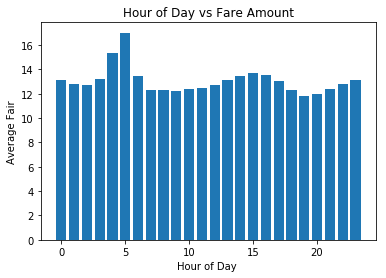

In [72]:
by_distance=ranged_data.groupby(by='hour_of_day')
#x = x.drop(x['day'] == 'Sunday')
x = by_distance.agg('mean')['fare_amount']
plt.bar(x.index,x)

plt.title("Hour of Day vs Fare Amount")
plt.xlabel("Hour of Day ")
plt.ylabel("Average Fair")
plt.show()

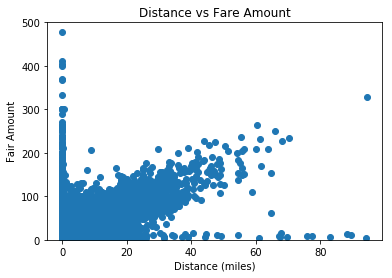

In [28]:
plt.scatter(ranged_data['distance'],ranged_data['fare_amount'])
plt.ylim(0,500)

plt.title("Distance vs Fare Amount")
plt.xlabel("Distance (miles)")
plt.ylabel("Fair Amount")



plt.show()


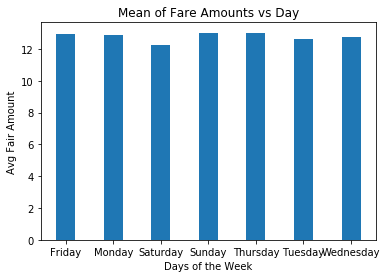

In [73]:
by_distance=ranged_data.groupby(by='day')
#x = x.drop(x['day'] == 'Sunday')
x = by_distance.agg('mean')['fare_amount']
width = 0.4
plt.bar(x.index, x, width)


plt.title("Mean of Fare Amounts vs Day")
plt.xlabel("Days of the Week")
plt.ylabel("Avg Fair Amount")
plt.show()

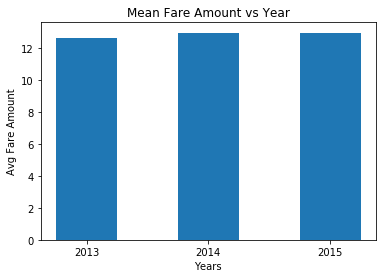

In [54]:
by_distance=ranged_data.groupby(by='year')
x = by_distance.agg('mean')['fare_amount']
width = 0.5
plt.bar(x.index, x, width)

plt.title("Mean Fare Amount vs Year")
plt.xlabel("Years")
plt.ylabel("Avg Fare Amount")
plt.xticks(x.index, ('2013','2014', '2015'))

plt.show()

In [45]:
x.index

Int64Index([2013, 2014, 2015], dtype='int64', name='year')

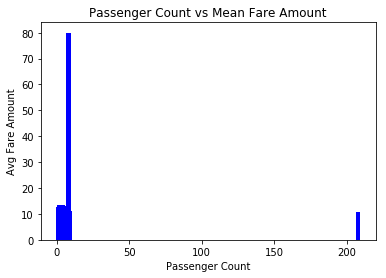

In [67]:


width = 3.0
plt.bar(x.index, x, width, color = "blue")
plt.title("Passenger Count vs Mean Fare Amount")
plt.xlabel("Passenger Count")
plt.ylabel("Avg Fare Amount")

plt.show()

Int64Index([2013, 2014, 2015], dtype='int64', name='year')